In [1]:
%load_ext autoreload
%autoreload 2
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, pickle, pyemma as py, sys, os
import pandas as pd
import seaborn as sns 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"
%matplotlib inline
from temp_tf_load import *
sys.path.append('../')
from hde import HDE, analysis
lag_time = 10
import warnings
warnings.filterwarnings('ignore')

print(tf.__version__)
print(py.__version__)



Using TensorFlow backend.


1.14.0
2.5.6


In [2]:
tf.__version__

'1.14.0'

In [3]:
# load thermo and pairwise distance features seperately
# only pwd features are used to train the model, thermo are for plotting

thermo_features = np.load('/home/mikejones/scratch-midway2/srv/dna_data/thermo-2831-1000-10.npy')[:500]
pwd_features = np.load('/home/mikejones/scratch-midway2/srv/dna_data/pwdr-2831-1000-190.npy')[:500]

scaler = pre.MinMaxScaler(feature_range=(-1, 1))

scaler.fit(np.concatenate(thermo_features))
thermo_features_s = [scaler.transform(item) for item in thermo_features]

scaler.fit(np.concatenate(pwd_features))
pwd_features_s = [scaler.transform(item) for item in pwd_features]

print(np.shape(thermo_features))
print(np.shape(pwd_features))


(500, 1000, 10)
(500, 1000, 190)


In [4]:
# define individual basepair distance features 

## HDE

In [5]:
skip = 1
from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)

n_sm = 6 

hde = HDE(190, n_components=n_sm, lag_time=lag_time // skip, dropout_rate=0, batch_size=500, n_epochs=10, 
          validation_split=0.2, batch_normalization=True, learning_rate = 0.01,
          callbacks=[earlyStopping])


In [6]:
# hde.r_degree = 10    # pre-training, to speed up discovery of first few slowest modes
# hde.batch_size = 200000
# hde.n_epochs = 50
# hde.fit(pairwise_dis_s)
# hde._recompile = True
# hde.r_degree = 5
# hde.fit(pairwise_dis_s)
# hde.batch_size = 500000
# hde._recompile = True
# hde.r_degree = 2
# hde.n_epochs = 100
# hde.fit(pairwise_dis_s)

In [7]:
hde.r_degree = 2
hde.n_epochs = 100
hde.fit(np.concatenate(pwd_features))


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 399992 samples, validate on 99998 samples
Epoch 1/100
399992/399992 [==============================] - 56s 140us/step - loss: -6.4533 - val_loss: -6.5256
Epoch 2/100
399992/399992 [==============================] - 63s 158us/step - loss: -6.5456 - val_loss: -6.5618
Epoch 3/100
399992/399992 [==============================] - 68s 169us/step - loss: -6.5835 - val_loss: -6.6076
Epoch 4/100
399992/399992 [==============================] - 53s 133us/step - loss: -6.6054 - val_loss: -6.6116
Epoch 5/100
399992/399992 [==============================] - 11s 28us/step - loss: -6.6202 - val_loss: -6.6215
Epoch 6/100
399992/399992 [==============================] - 11s 27us/step - loss: -6.6277 - val_loss: -6.6181
Epoch 7/100
399992/399992 [==============================] - 11s 27us/step - loss: -6.6285 - val_loss: -6.6308
Epoch 8/100
399992/3999

399992/399992 [==============================] - 9s 23us/step - loss: -6.6613 - val_loss: -6.6439
Epoch 68/100
399992/399992 [==============================] - 9s 23us/step - loss: -6.6724 - val_loss: -6.6531
Epoch 69/100
399992/399992 [==============================] - 9s 22us/step - loss: -6.6624 - val_loss: -6.6375
Epoch 70/100
399992/399992 [==============================] - 9s 24us/step - loss: -6.6541 - val_loss: -6.6464
Epoch 71/100
399992/399992 [==============================] - 9s 22us/step - loss: -6.6697 - val_loss: -6.6479
Epoch 72/100
399992/399992 [==============================] - 9s 24us/step - loss: -6.6606 - val_loss: -6.6032
Epoch 73/100
399992/399992 [==============================] - 9s 23us/step - loss: -6.6651 - val_loss: -6.6431
Epoch 74/100
399992/399992 [==============================] - 9s 22us/step - loss: -6.6735 - val_loss: -6.6284
Epoch 75/100
399992/399992 [==============================] - 9s 23us/step - loss: -6.6668 - val_loss: -6.6316
Epoch 76/100
3

HDE(activation=None, batch_normalization=True, batch_size=500,
    callbacks=[<keras.callbacks.EarlyStopping object at 0x7f4108256ba8>],
    dropout_rate=0, hidden_layer_depth=None, hidden_size=None, input_size=190,
    l2_regularization=0.0, lag_time=10, latent_space_noise=0,
    learning_rate=0.01, n_components=6, n_epochs=100, validation_split=0.2,
    verbose=True)

In [8]:
hde_coords = [hde.transform(item) for item in pwd_features]
hde_timescales = hde.timescales_
print(hde_timescales)

[571.89617253 460.4446213  400.89454778 380.44764939 356.76984042
 260.19803661]


In [9]:
## make pandas data frame

skip = 10    #num coords to skip on plot
num_bp = 10

hde_coords_conc = np.concatenate(hde_coords[::skip])
thermo_features_conc = np.concatenate(thermo_features[::skip])
pwd_features_conc = np.concatenate(pwd_features[::skip])

index_size = len(hde_coords_conc[:, 0])

print (np.shape(hde_coords_conc))
print (np.shape(thermo_features_conc))
print (np.shape(pwd_features_conc))

## take distances features for each basepair:
bp_match_list = [i*11 for i in range (num_bp)]
bp_match_conc = np.zeros((index_size, len(bp_match_list)))

for i, val in enumerate(bp_match_list):
    bp_match_conc[:, i] = pwd_features_conc[:, val]
    
df_bp = pd.DataFrame(data    = bp_match_conc, 
                   columns = bp_match_list,
                   index   = np.linspace(1, index_size, index_size))


hde_col_list = ['1st_EF', '2nd_EF', '3rd_EF', '4th_EF', '5th_EF', '6th_EF', '7th_EF']
df_hde = pd.DataFrame(data    = hde_coords_conc, 
                   columns = hde_col_list[:n_sm],
                   index   = np.linspace(1, index_size, index_size))

feature_col_list = ['Step', 'nbp', 'E_bond', 'E_angle', 'E_dihed', 'ebp', 'ecstk', 'eexcl', 'dna_ecou', 'Temp']

#make additional df column for timestep
lin_x = [i for i in range(len(thermo_features[0]))] 
lin_x_list = []
for i in range(len(thermo_features)):
    lin_x_list.append(lin_x)
    
lin_x_conc = np.concatenate(lin_x_list[::skip])

df_thermo =  pd.DataFrame(data    = thermo_features_conc, 
                   columns = feature_col_list, 
                   index   = np.linspace(1, index_size, index_size))

df_thermo['time_traj'] = lin_x_conc
                          
df = df_hde.join(df_thermo)
df = df.join(df_bp)

print(df.head())

(50000, 6)
(50000, 10)
(50000, 190)
       1st_EF    2nd_EF    3rd_EF    4th_EF    5th_EF    6th_EF       Step  \
1.0  0.367390 -0.514727 -0.860968  2.047630 -1.811927 -1.077364  3527400.0   
2.0  0.362448 -0.511051 -0.855708  2.027240 -1.798427 -1.052093  3527600.0   
3.0  0.367460 -0.512116 -0.862094  2.027573 -1.804178 -1.031447  3527800.0   
4.0  0.366021 -0.511070 -0.857892  2.032312 -1.802257 -1.054714  3528000.0   
5.0  0.370814 -0.513889 -0.867388  2.029286 -1.809638 -1.017863  3528200.0   

     nbp     E_bond    E_angle  ...         0        11        22        33  \
1.0  7.0   8.324342 -29.950151  ...  0.042869  0.046866  0.052089  0.056658   
2.0  4.0   6.445622 -32.812265  ...  0.037723  0.041893  0.048903  0.054847   
3.0  7.0   9.756880 -32.307925  ...  0.035078  0.043896  0.053101  0.063056   
4.0  7.0  11.000484 -27.607293  ...  0.035225  0.042936  0.051547  0.061633   
5.0  9.0   7.941992 -20.630030  ...  0.035078  0.043872  0.051486  0.059389   

           44       

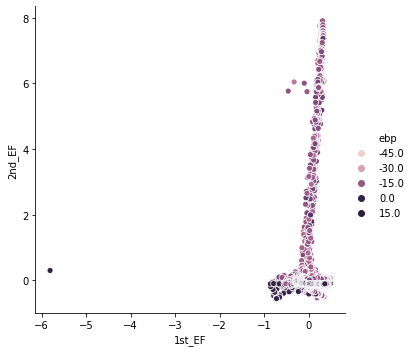

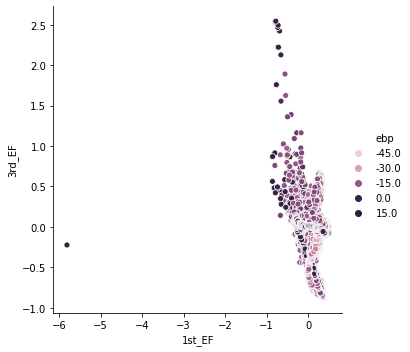

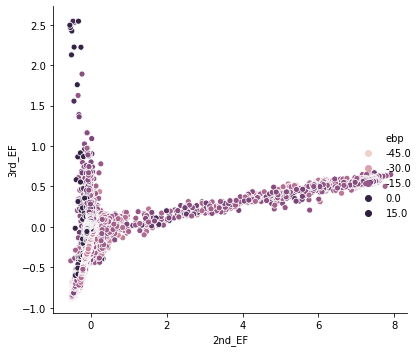

In [10]:
## Graphing slow modes and using physical properties as color gradients
## thermo_features index: 
# Step(0) nbp(1) E_bond(2) E_angle(3) E_dihed(4) ebp(5) ecstk(6) eexcl(7) dna_ecou(8) Temp(9)

#f, axes = plt.subplots(3, 1)
#sns.despine(left=True)

sns.relplot(data = df,
            x = "1st_EF", 
            y = "2nd_EF", 
            hue = "ebp",
            #ax=axes[0]
            )

sns.relplot(data = df,
            x = "1st_EF", 
            y = "3rd_EF", 
            hue = "ebp",
            #ax=axes[1]
            )

sns.relplot(data = df,
            x = "2nd_EF", 
            y = "3rd_EF", 
            hue = "ebp",
            #ax=axes[2]
            )

plt.tight_layout()
#plt.show()


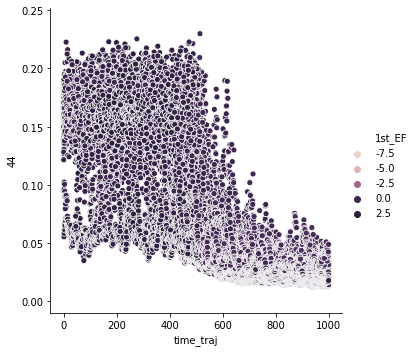

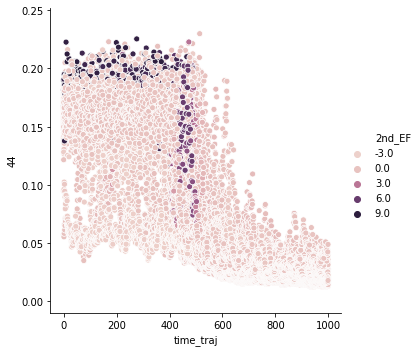

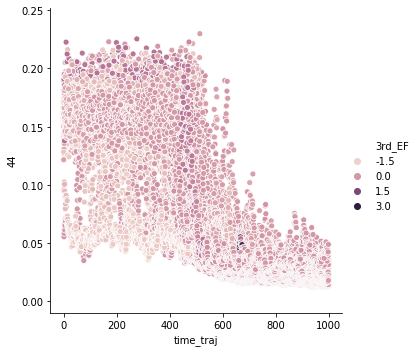

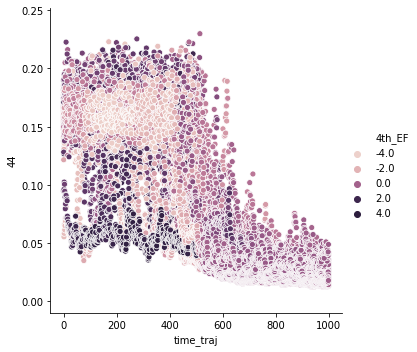

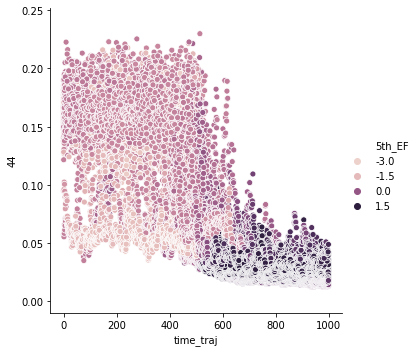

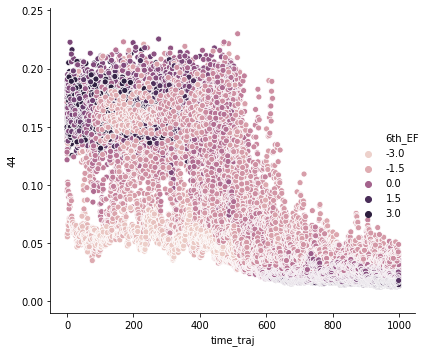

In [11]:
## Graphing physical property comparisons and using slow modes as color gradient
## thermo_features index: 
# Step(0) nbp(1) E_bond(2) E_angle(3) E_dihed(4) ebp(5) ecstk(6) eexcl(7) dna_ecou(8) Temp(9) time_traj (10)

for i in range(n_sm):
    sns.relplot(data = df,
            x = "time_traj", 
            y = 44, 
            hue = hde_col_list[i],
            )


plt.tight_layout()



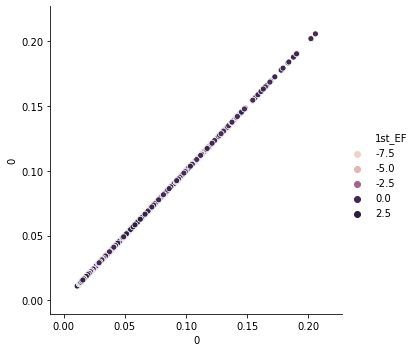

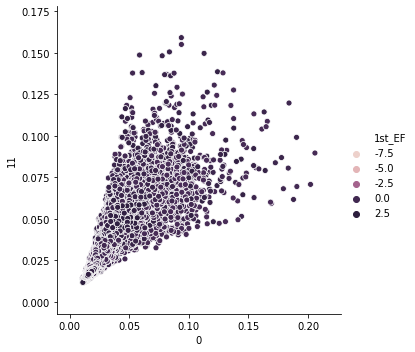

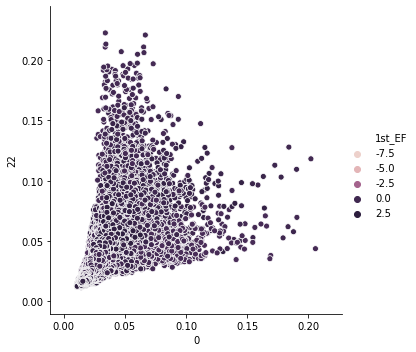

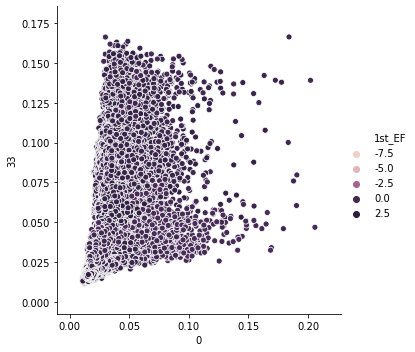

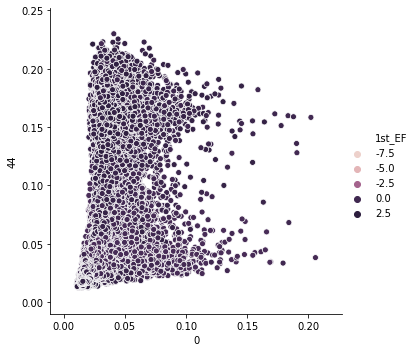

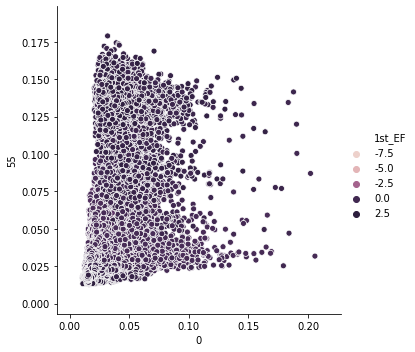

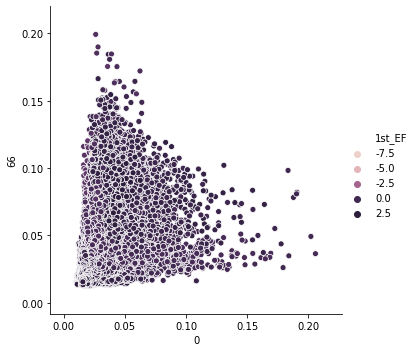

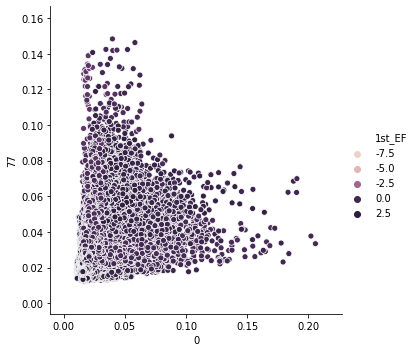

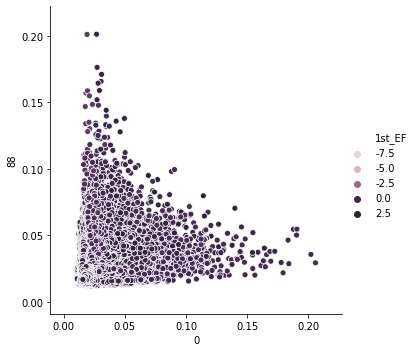

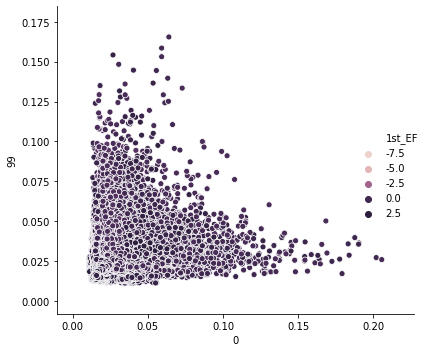

In [12]:
for i in range(num_bp):
    sns.relplot(data = df,
            x = 0, 
            y = i*11, 
            hue = "1st_EF",
            )


plt.tight_layout()